# Vanishing gradient problem
 In this exercise you are to write a computer program to train a perceptron with four fully connected hidden layers. The network consists of L=5 layers, and your hidden layers are layers $\ell=1$ to $\ell=4$. Each hidden layer has 20 hidden neurons. The perceptron is trained on the CIFAR-10 data. Therefore it must have 3072 input units and 10 output units. Use activation functions as in the first exercise, and train the network using the same training algoritm as in that exercise.

Train using the same mini-batch size $m_B$ as in the first exercise. Also, initialise weights and thresholds in the same way, and zero-center the input data in the same way. Use neither regularisation nor momentum. Use a learning rate $\eta = 0.01$ so that, for each mini-batch, the increment of a weight $w_{mn}^{(\ell)}$ is given by $\delta w_{mn}^{(\ell)} = \eta \sum_{\mu=1}^{m_B}\delta_m^{(\ell,\mu)}V_n^{(\ell-1,\mu)} \,$. The summation is over the patterns in the mini-batch. Here, $\delta_m^{(\ell,\mu)}$ denotes the error of the $m^\text{th}$ neuron in the $\ell^\text{th}$ layer evaluated for the $\mu^\text{th}$ pattern in the mini-batch. The state of the $n^\text{th}$ neuron in the $(\ell-1)^\text{th}$ layer evaluated for pattern $\mu$ is denoted by $V_n^{(\ell-1,\mu)}$.

### Learning speed

Consider the vector $\underline{u}^{(\ell)}$ with elements given by $u_i^{(\ell)} = \frac{\partial H}{\partial \theta_i^{(\ell)}}$. Here, H is the same energy function as specified in the first exercise, evaluated for all the training data. In the denominator $\theta_i^{(\ell)}$ denotes the threshold of the $i^\text{th}$ neuron in the $\ell^\text{th}$ layer. The norm of $\underline{u}^{(\ell)}$, $U^{(\ell)} \equiv |\underline{u}^{(\ell)}|$, is a measure of how fast the thresholds in the $\ell^\text{th}$ layer change, that is: the speed at which they learn. We will refer to $U^{(\ell)}$ as the learning speed of layer $\ell$.

Your task is to study the learning speed of the different hidden layers of your network. To do this, train your network for 100 epochs, using the parameters and algorithm described above. Train using the training data. You don't need to use the validation or test data in this exercise.

In [1]:
import numpy as np
from numpy import random as rnd
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

def unpickle(file):
    "Returns an a dictionary of a single batch, if filename is correct"
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def calculate_mean(x_train):
    "Calculate the mean of a set of training data"
    mean = np.mean(x_train,axis=0)
    return mean


def center_data(x_train):

    mean = calculate_mean(x_train)
    centered_data = x_train - mean
    centered_data /= 255
    #centered_data = centered_data.astype(np.uint8)
    return centered_data

def sigmoid_activation_function(b):

    
    return np.power((1+np.exp(-b)), -1)


def shuffle(X, y):
    '''
    Shuffle two corresponding arrays
    '''
    assert len(X) == len(y)
    random = np.arange(len(X))
    np.random.shuffle(random)
    X = X[random]
    y = y[random]
    return X, y


def g(b):
    
    return sigmoid_activation_function(b)

def dg(b):
    
    o_b = sigmoid_activation_function(b)
    return o_b*(1-o_b)

def create_layer(inputsize, layersize):
    
    neurons = np.zeros((layersize,1))
    neurons = neurons.reshape(layersize,1)
    w_ij = rnd.normal(size=(layersize, inputsize),scale= (1/(np.sqrt(inputsize))))
    return (neurons, w_ij)

def esign(i):
    
    if i == 0:
        return 1
    return np.sign(i)

def calculate_output(threshold, weight_matrix, x):
    
    if weight_matrix.shape[1]==1:
        weight_matrix = weight_matrix.T
    inner_sum = weight_matrix@x
    inner_sum = inner_sum - threshold
    ret = g(inner_sum)
    assert(ret.shape == threshold.shape)
    return ret

def calculate_output_batch(threshold, weight_matrix, V, batchsize):
    
    inner_sum = weight_matrix@V
    inner_sum = inner_sum.reshape((threshold.shape[0],batchsize))
    inner_sum = inner_sum - threshold
    ret = g(inner_sum)
    assert(ret.shape == (threshold.shape[0],batchsize))
    return ret



def propagate_forward(V : list, O : list, w : list, batchsize : int) -> None:

    assert(len(V)-1==len(O) and len(O)==len(w))

    for l in range(1,len(V)):
        V[l]= calculate_output_batch(O[l-1],w[l-1],V[l-1], batchsize)


def calculate_b(w, x, O):
    
    inner_sum = np.dot(w,x)
    inner_sum = inner_sum - O
    return inner_sum

def calculate_d_L(b, t, V):
    
    return dg(b)(t-V)

def calculate_single_d(d_l, w, b):
    
    dgb = dg(b)
    inner_product = (d_l.T@w).T
    ret = np.multiply(inner_product,dgb)
    return ret


def calculate_all_d(V, O, w, t):
    
    L = len(O)-1
    b_L = calculate_b(w[L],V[L], O[L])
    b_L = dg(b_L)
    temp = (t-V[-1])
    delta_start = b_L*temp
    d = [[]]*(L+1)
    d[L] = delta_start
    for i in range(L, 0, -1):
        #TODO make sure the range function works as intended
        if(w[i].shape[1]==1):
            w[i] = w[i].T

        b =  calculate_b(w[i-1],V[i-1],O[i-1])
        delta = calculate_single_d(d[i],w[i],b)
        d[i-1] = delta
    return d



def propagate_backwards(V : list, O : list, w : list, t : int, learning_rate: float, batchsize : int):

    L = len(w)
    d = calculate_all_d(V,O,w,t) 
    for l in range(L):
        if(w[l].shape[1]==1):
            d_w = learning_rate*(d[l]@V[l])
        else:
            d_w = learning_rate*(d[l]@V[l].T)
        d_O = learning_rate* (d[l]@np.ones((batchsize,1)))
        w[l] +=  d_w
        O[l] -= d_O


def create_multible_layers(*argv):
    
    w = []
    V = []
    O = []
    inputlayer = np.zeros((argv[0],1))
    V.append(inputlayer)
    old_layersize = argv[0]
    for layersize in argv[1:]:
        O_i = np.zeros((layersize,1))
        V_i, w_i = create_layer(old_layersize,layersize)
        old_layersize = layersize    
        w.append(w_i)
        V.append(V_i)
        O.append(O_i)
    return (w,V,O)


def learn(learning_rate:float, data: list, labels: list,test_data : list, test_labels : list, batchsize: int, *argv):

    w,V,O = create_multible_layers(*argv)
    #merged = np.concatenate([data, labels], axis=1)
    ret = defaultdict(list)
    #TODO create a dictionary
    return_w = []
    return_c = []
    return_O = []
    return_H = []
    return_u = []
    for T in range(100):
        #Permutate the data in the beginning of each epoch
        data,labels = shuffle(data,labels)
        for i in range(0, len(data), batchsize):
            my = i
            bs = batchsize
            if my + batchsize >= len(data):
                bs =  len(data) - my
            V[0] = np.array(data[my:my+bs]).T
            t = np.array(labels[my:my+bs]).T
            #t = t.reshape(bs,t.shape[1])
            
            propagate_forward(V,O,w, bs)
            propagate_backwards(V,O,w,t,learning_rate, bs)
        #print(w[0])
        #C = calculate_classification_error(V,w,O,test_data, test_labels)
        #print(w[0])
        newH, new_u = calculate_H_and_U(V,w,O,data, labels)
        return_H.append(newH)
        return_u.append(new_u)
        #return_c.append(C)
        return_w.append(w)
        return_O.append(O)
    print("Finished learning!")
    ret["H"] = return_H
    ret["u"] = return_u
    ret["w"] = return_w
    ret["O"] = return_O
    ret["C"] = return_c
    return ret

def calculate_H_and_U(V,w,O,training_set, label_set):
    
    H = 0
    #initialize u(l)
    u = []
    for O_l in O:
        u.append(np.zeros(O_l.shape))
    batchsize = 100
    for i in range(0,len(training_set),batchsize):
        my = i
        bs = batchsize
        if my + batchsize >= len(data):
            bs =  len(training_set) - my
        V[0] = training_set[my:my+bs].T
        t = label_set[my:my+bs].T
        propagate_forward(V,O,w,bs)

        #Update H
        y_i = np.argmax(V[-1],axis=0)
        y_i = y_i.tolist()
        transformlabels(y_i,10)
        y_i = np.array(y_i).T
        y_i = y_i.reshape(10,bs)
        temp = y_i - t 
        H += np.sum(np.abs(y_i-t))
        
        #update u
        d = calculate_all_d(V,O,w,t)
        for l in range(len(u)):
            u[l] += (d[l]@np.ones((batchsize,1)))
            
    for l in range(len(u)):
        u[l] = np.linalg.norm(u[l])
    return H/2, u

         


def calculate_classification_error(V,w,O, test_data, test_labels):
    
    inner_sum = 0
    pval = len(test_data)
    for my in range(pval):
        V[0] = np.array(test_data[my])
        t_my = test_labels[my]
        #Propagate Forward
        propagate_forward(V,O,w,1)
        #inner_sum += np.abs(esign(V[-1][0])-t_my)
        y_i = np.argmax(V[-1],axis=0)
        y = np.zeros((len(V[-1]),1))
        #print(y_i)
        y[y_i] = 1
        inner_sum += np.sum(np.abs(y-t_my))
        #print("error")
    return inner_sum/(2*pval)



def transformlabels(labels, n):
    "Transforms labels from numbers to vectors of 0 and 1"
    for i,label in enumerate(labels):
        temp = np.zeros((n,1))
        temp[label] = 1
        labels[i] = temp





Load data

In [2]:
folder_name = "../data/cifar-10-batches-py/"
batch_1 = unpickle(folder_name+"data_batch_1")
batch_2 = unpickle(folder_name+"data_batch_2")
batch_3 = unpickle(folder_name+"data_batch_3")
batch_4 = unpickle(folder_name+"data_batch_4")
batch_5 = unpickle(folder_name+"data_batch_5")

data = batch_1[b'data']
data = np.append(data,batch_2[b'data'], axis=0)
data = np.append(data,batch_3[b'data'], axis=0)
data = np.append(data,batch_4[b'data'], axis=0)
data = np.append(data,batch_5[b'data'], axis=0)
labels = batch_1[b'labels']
#Since labels are only a normal array
labels += batch_2[b'labels']
labels += batch_3[b'labels']
labels += batch_4[b'labels']
labels += batch_5[b'labels']
data = center_data(data)
transformlabels(labels,10)
labels = np.array(labels)
labels = labels.astype(np.uint8)
labels = np.array(labels).reshape(50000,10)

test_batch = unpickle(folder_name+"test_batch")
test_data = batch_5[b'data']
test_labels = batch_5[b'labels']
test_data = center_data(test_data)
transformlabels(test_labels,10)
test_labels = np.array(test_labels)

test_labels = test_labels.astype(np.uint8)


Start learning

In [3]:
learning_rate = 0.01
batchsize = 100
ret_dic = learn(learning_rate, data,labels,[],[],batchsize,3072, 20,20,20,20,10)

Finished learning!


Let's visualize our results

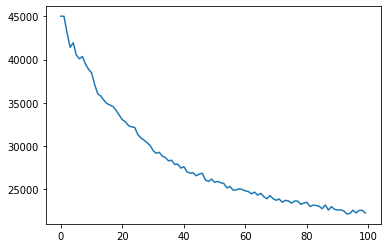

In [4]:
plt.plot(ret_dic["H"])
plt.show()

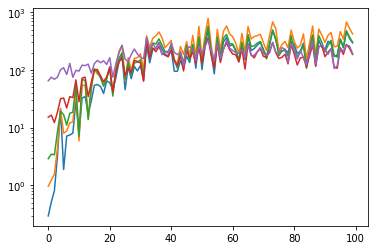

In [7]:
u = ret_dic["u"]
for u_l in np.array(u).T:
    plt.plot(u_l)
plt.yscale('log')
plt.show()

## Discussion
As expected the Energy function decreases over the span of the learning.  It is notable, that the learning in the beginning is much faster and later slows down. You can see the vanishing gradient problem in this slowing down, in the energy function, but also in the lack of change of the learning rate of each layer.

The learning rate of the different layers in the beginning has quite a variety. The closer the layer is to the output layer, the higher the learning rate is. But as the learning continues the learning rates converge and show a very similar course approximately from epoch 20  on.
The converging happens approximately for the first 20 episodes, where the layers with lower starting rate of learning show a much steeper increase until they finally reach the same level of learning rate as the other layers.